# Implementation of Deep Convolutional GANs
Reference: https://arxiv.org/pdf/1511.06434.pdf

In [ ]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [2]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 31kB/s 
     |████████████████████████████████| 6.5MB 23.3MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [4]:
!cp '/content/drive/My Drive/eva4_phase2_datasets/final_car_images.zip' .


In [5]:
!unzip -qq final_car_images.zip

In [6]:
!mkdir -p '/content/drive/My Drive/eva4_phase2_output/gan_new_collage_images_500_1'

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [9]:
import numpy as np
import datetime
import os, sys

In [10]:
import glob

In [11]:
from PIL import Image

In [12]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [13]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
#IMAGE_DIM = (32, 32, 3)
IMAGE_DIM = (128, 128, 3)

In [15]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(10, n_noise).to(DEVICE)
    #y_hat = G(z).view(10, 3, 32, 32).permute(0, 2, 3, 1) # (100, 28, 28)
    y_hat = G(z).view(10, 3, 128, 128).permute(0, 2, 3, 1) # (100, 28, 28)
    result = (y_hat.detach().cpu().numpy()+1)/2.
    return result

In [16]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # 
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
        )        
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [17]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, out_channel=1, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        assert IMAGE_DIM[0] % 2**4 == 0, 'Should be divided 16'
        self.init_dim = (IMAGE_DIM[0] // 2**4, IMAGE_DIM[1] // 2**4)
        self.fc = nn.Sequential(
            nn.Linear(input_size, self.init_dim[0]*self.init_dim[1]*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, out_channel, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, self.init_dim[0], self.init_dim[1])
        y_ = self.conv(y_)
        return y_

In [19]:
class CARS(Dataset):
    '''
    CARS Dataset
    You should download this dataset from below url.
    url: https://ai.stanford.edu/~jkrause/cars/car_dataset.html
    '''
    def __init__(self, data_path, transform=None):
        '''
        Args:
            data_path (str): path to dataset
        '''
        self.data_path = data_path
        self.transform = transform
        self.fpaths = sorted(glob.glob(os.path.join(data_path, '*.jpg')))
        #gray_lst = [266, 1085, 2176, 3048, 3439, 3469, 3539, 4577, 4848, 5177, 5502, 5713, 6947, 7383, 7693, 7774, 8137, 8144]
        #for num in gray_lst:
        #    self.fpaths.remove(os.path.join(data_path, '{:05d}.jpg'.format(num)))
        
    def __getitem__(self, idx):
        img = self.transform(Image.open(self.fpaths[idx]))
        return img

    def __len__(self):
        return len(self.fpaths)

In [20]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1]).to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [21]:
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ]
)

In [22]:
dataset = CARS(data_path='/content', transform=transform)

In [23]:
batch_size = 64

In [24]:
#data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [25]:
sample= next(iter(data_loader))
print(sample.shape)


torch.Size([64, 3, 128, 128])


In [26]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

In [27]:
max_epoch = 10000
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_discr = 3
n_noise = 100

In [28]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [29]:
def generate_and_save_collage(img_list, path):
    new_im = Image.new('RGB', (640 , 256))
    for i in range(2):
        for j in range(int(len(img_list)/2)):
            img_array= 255*img_list[i*5 + j]
            pil_img = Image.fromarray(img_array.astype('uint8'), 'RGB')
            new_im.paste(pil_img, (128*j, 128*i))
    new_im.save(path)
    

In [30]:
for epoch in range(max_epoch):
    for idx, images in enumerate(data_loader):
        if step % n_discr == 0:
          # Training Discriminator
          x = images.to(DEVICE)
          x_outputs = D(x)
          D_x_loss = criterion(x_outputs, D_labels)

          z = torch.randn(batch_size, n_noise).to(DEVICE)
          z_outputs = D(G(z))
          D_z_loss = criterion(z_outputs, D_fakes)
          D_loss = D_x_loss + D_z_loss
        
          D.zero_grad()
          D_loss.backward()
          D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), dt))
            G.eval()
            img = get_sample_image(G, n_noise)
            image_save_path = '/content/drive/My Drive/eva4_phase2_output/gan_new_collage_images_500_1/{}_step{:05d}.jpg'.format(MODEL_NAME, step)

            #generate_and_save_collage(img, '/content/drive/My Drive/eva4_phase2_datasets/gan_new_collage_images/{}_step{:05d}.jpg'.format(MODEL_NAME, step))
            generate_and_save_collage(img, image_save_path)
            torch.save(G.state_dict(), '/content/drive/My Drive/eva4_phase2_models/gan_generate_500_1_model_step_' + str(step) +".pth" )
            #imsave('/content/drive/My Drive/eva4_phase2_datasets/gan_new_collage_images/{}_step{:05d}.jpg'.format(MODEL_NAME, step), img[0])

            G.train()
    step += 1

Epoch: 0/10000, Step: 0, D Loss: 1.3927, G Loss: 0.8709, Time:05:15:00
Epoch: 0/10000, Step: 0, D Loss: 1.4078, G Loss: 0.8566, Time:05:15:01
Epoch: 0/10000, Step: 0, D Loss: 1.4065, G Loss: 0.8490, Time:05:15:02
Epoch: 0/10000, Step: 0, D Loss: 1.3922, G Loss: 0.8237, Time:05:15:03
Epoch: 0/10000, Step: 0, D Loss: 1.3577, G Loss: 0.8054, Time:05:15:04
Epoch: 0/10000, Step: 0, D Loss: 1.3273, G Loss: 0.7902, Time:05:15:05
Epoch: 500/10000, Step: 500, D Loss: 1.3400, G Loss: 0.6438, Time:05:30:03
Epoch: 500/10000, Step: 500, D Loss: 1.3400, G Loss: 0.6335, Time:05:30:04
Epoch: 500/10000, Step: 500, D Loss: 1.3400, G Loss: 0.6265, Time:05:30:04
Epoch: 500/10000, Step: 500, D Loss: 1.3400, G Loss: 0.6181, Time:05:30:05
Epoch: 500/10000, Step: 500, D Loss: 1.3400, G Loss: 0.6120, Time:05:30:06
Epoch: 500/10000, Step: 500, D Loss: 1.3400, G Loss: 0.6072, Time:05:30:07
Epoch: 1000/10000, Step: 1000, D Loss: 1.3523, G Loss: 0.7198, Time:05:45:07
Epoch: 1000/10000, Step: 1000, D Loss: 1.3523, 

In [ ]:
MODEL_PATH = '/content/drive/My Drive/eva4_phase2_models/gan_generate_model_step_2500.pth'
model_cpu = G.to('cpu')
traced_model = torch.jit.trace(model_cpu, torch.randn(1,3, 224, 224))
traced_model.save(MODEL_PATH)

RuntimeError: ignored

In [ ]:
!ls -l '/content/drive/My Drive/eva4_phase2_models/gan_generator_200.pt'



## Sample

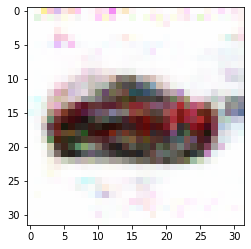

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise)[9])

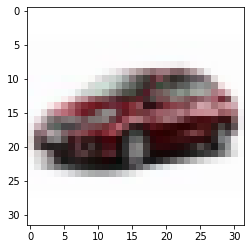

In [ ]:
# Real Image
t = Image.open(dataset.fpaths[100])
t = (transform(t).permute(1, 2, 0)+1)/2.
imshow(t)

In [ ]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [ ]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1,
                 'D':D.state_dict(),
                 'G':G.state_dict(),
                 'd_optim': D_opt.state_dict(),
                 'g_optim' : G_opt.state_dict()},
                '/content/drive/My Drive/eva4_phase2_models/dcgan.pth.tar')